In [1]:
import plotly.express as px
import pandas as pd
from tqdm import tqdm
import geopy.distance
import math
import seaborn as sns
import smoothfit
import matplotlib.pyplot as plt
import os
%matplotlib notebook

In [2]:
# fn = "/Users/anish/Desktop/cia-0408/processed/2023_04_08_12_40_18_roll.pos"
# fn = "/Users/anish/temp/output.pos"
fn = "data/output.pos"


In [3]:
#lines = lines[1000:]

In [16]:
MAX_STDDEV = 0.4
MIN_SATELLITES = 2
ALLOWED_FIXTYPES = {1: 2, 2: 1, 4: 0} # convert between RTKLIB format and our format
########ALLOWED_FIXTYPES = {1: 2, 2: 1, 4: 0, 5: 0, 6: 0} # convert between RTKLIB format and our format


def parsefile(fn):
    with open(fn) as f:
        lines = [x.strip() for x in f.readlines()]
        lines = [x for x in lines if not x.startswith("%")]
        lines = [[x.strip() for x in line.split(",")] for line in lines]

    out = []

    last_pos = None
    last_vel = None

    for timestr, lat, lng, alt, fixtype, ns, sdn, sde, sdu, _, _, _, _, _ in lines:
        #print(fixtype)
        h, m, s = timestr.split(" ")[-1].split(":")
        ts = int(h)*60*60 + int(m)*60 + float(s)
        ts = round(ts, 3)

        lat = float(lat)
        lng = float(lng)
        alt = float(alt)
        fixtype = int(fixtype)
        ns = int(ns)
        sdn = float(sdn)
        sde = float(sde)
        sdu = float(sdu)

        #if fixtype not in ALLOWED_FIXTYPES:
        #    continue

        horiz_acc = round(math.sqrt(sdn**2 + sde**2), 4) # TODO this is not statistically accurate
        vert_acc = round(sdu, 4) # TODO this may or may not need some math done on it

        #if horiz_acc > MAX_STDDEV:
        #    continue

        if ns < MIN_SATELLITES:
            continue

        # TODO fit some kind of curve to compute a smooth measurement of speed
        if last_pos:
            diff = geopy.distance.geodesic((last_pos[0], last_pos[1]), (lat, lng)).meters

            timediff = (ts - last_pos[2])
            ground_speed_raw = round((diff/timediff)*2.23694, 4) # convert to mph

            if last_vel:
                acceleration = (ground_speed_raw - last_vel[0]) / (ts - last_vel[1])   
            else:
                acceleration = 0

            last_vel = (ground_speed_raw, ts)

            if acceleration > 100 or ground_speed_raw > 45:
                continue

            speed_acc = 0 # TODO
        else:
            last_pos = (lat, lng, ts)
            continue

        last_pos = (lat, lng, ts)

        msg = {
            "timestamp": ts,
            "rtktype": ALLOWED_FIXTYPES[fixtype],
            "latitude": lat,
            "longitude": lng,
            "ground_speed_raw": ground_speed_raw, # mph
            "ground_speed": ground_speed_raw, # mph, TODO: should be smoothed
            "altitude": alt, # meters
            "horizontal_accuracy": horiz_acc,
            "vertical_accuracy": vert_acc,
            "speed_accuracy": speed_acc
        }

        out.append(msg)
        
    return out

def parsefilewithname(fn, bn=None):
    if bn is None: bn = os.path.basename(fn)
    return [{**x, "file": bn} for x in parsefile(fn)]

In [17]:
#out3 = parsefilewithname("/Users/anish/temp/out/output3.pos", "combined fwd+bwd solution")
#out4 = parsefilewithname("/Users/anish/temp/out/output4.pos", "fwd solution")
#out5 = parsefilewithname("/Users/anish/temp/out/output5.pos", "bwd solution")
#out6 = parsefilewithname("/Users/anish/temp/out/output6.pos", "bwd solution (instantaneous integer ambiguity res.)")
#out7 = parsefilewithname("/Users/anish/temp/out/output7.pos", "fwd solution (instantaneous integer ambiguity res.)")#

In [18]:
out = parsefilewithname(fn, fn)

In [19]:
df = pd.DataFrame.from_dict(out)

In [20]:
df

timestamp  rtktype   latitude  longitude  ground_speed_raw  \
0        38220.1        1  40.441707 -79.941235            0.0308   
1        38220.2        1  40.441707 -79.941235            0.0202   
2        38220.3        1  40.441707 -79.941235            0.0222   
3        38220.4        1  40.441707 -79.941235            0.0249   
4        38220.5        1  40.441707 -79.941235            0.0231   
...          ...      ...        ...        ...               ...   
26736    43737.6        1  40.441696 -79.941106            0.0600   
26737    43737.7        1  40.441696 -79.941106            0.0585   
26738    43737.8        1  40.441696 -79.941106            0.0497   
26739    43737.9        1  40.441696 -79.941106            0.0761   
26740    43738.0        1  40.441696 -79.941106            0.0616   

       ground_speed  altitude  horizontal_accuracy  vertical_accuracy  \
0            0.0308  264.0627               0.0208             0.0301   
1            0.0202  264.0628               0.0208             0.0301   
2            0.0222  264.0622               0.0208             0.0301   
3            0.0249  264.0616               0.0208             0.0301   
4            0.0231  264.0610               0.0208             0.0301   
...             ...       ...                  ...                ...   
26736        0.0600  267.2487               0.0493             0.0676   
26737        0.0585  267.2410               0.0493             0.0676   
26738        0.0497  267.2416               0.0493             0.0676   
26739        0.0761  267.2342               0.0493             0.0676   
26740        0.0616  267.2420               0.0493             0.0676   

       speed_accuracy                          file  
0                   0  /Users/anish/temp/output.pos  
1                   0  /Users/anish/temp/output.pos  
2                   0  /Users/anish/temp/output.pos  
3                   0  /Users/anish/temp/output.pos  
4                   0  /Users/anish/temp/output.pos  
...               ...                           ...  
26736               0  /Users/anish/temp/output.pos  
26737               0  /Users/anish/temp/output.pos  
26738               0  /Users/anish/temp/output.pos  
26739               0  /Users/anish/temp/output.pos  
26740               0  /Users/anish/temp/output.pos  

[26741 rows x 11 columns]

In [21]:
#out1 = out[:]

In [22]:
#df = pd.DataFrame.from_dict(out+out1)

In [23]:
#sns.lineplot(data=pd.DataFrame.from_dict(out6), x="timestamp", y="ground_speed_raw")
#sns.lineplot(data=pd.DataFrame.from_dict(out7), x="timestamp", y="ground_speed_raw")

In [24]:
df["ground_speed_raw"].max(), df["ground_speed_raw"].min()

(41.7871, 0.0)

In [25]:
df.to_csv(fn.replace(".pos", ".csv"))

In [26]:
ll = list(df["timestamp"])
oo = []
for i in range(len(ll)-1):
    oo.append(round(ll[i+1]-ll[i], 2))
    
print({x: oo.count(x) for x in set(oo)})

#plt.hist(oo, bins=30)

{0.4: 245, 0.2: 804, 0.5: 139, 1.5: 30, 0.8: 73, 0.6: 116, 0.3: 396, 1.3: 45, 1.4: 50, 1.0: 61, 3.2: 12, 2.8: 14, 2.0: 30, 5.7: 2, 2.5: 14, 7.1: 1, 3.0: 7, 3.5: 6, 4.6: 6, 4.0: 9, 4.4: 8, 4.1: 2, 4.9: 1, 4.5: 2, 5.4: 1, 5.9: 1, 5.6: 1, 5.5: 1, 6.6: 1, 5.0: 2, 6.9: 1, 6.0: 1, 7.5: 1, 7.6: 1, 1.1: 46, 1.6: 40, 8.0: 1, 8.7: 1, 2.1: 25, 2.6: 15, 3.1: 10, 0.7: 77, 3.6: 5, 1.2: 46, 1.7: 26, 0.1: 24131, 2.2: 23, 2.7: 12, 2.3: 19, 973.3: 1, 3.8: 6, 3.7: 5, 3.3: 7, 4.2: 3, 1.8: 36, 4.3: 3, 5.2: 2, 6.2: 2, 1.9: 21, 0.9: 67, 2.9: 9, 2.4: 14, 3.9: 3}


In [27]:
layers = [
    {
        "below": "traces",
        "sourcetype": "raster",
        "source": [
            "https://imagery.pasda.psu.edu/arcgis/rest/services/pasda/PEMAImagery2018_2020/MapServer/WMTS/tile/1.0.0/pasda_PEMAImagery2018_2020/default/default028mm/{z}/{y}/{x}.png"
        ]
    }
]

fig = px.scatter_mapbox(df,
                        lat="latitude", lon="longitude",
                        color="ground_speed",
                        hover_data=["horizontal_accuracy",
                                    "speed_accuracy",
                                    "altitude",
                                    "timestamp",
                                    "rtktype"],
                        zoom=15, size_max=18,
                        height=400, width=800)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=layers
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [75]:
#fig.write_html("example_of_weird_behavior.html")

In [123]:
fig.write_html(fn.replace(".pos", ".html"))

<IPython.core.display.Javascript object>


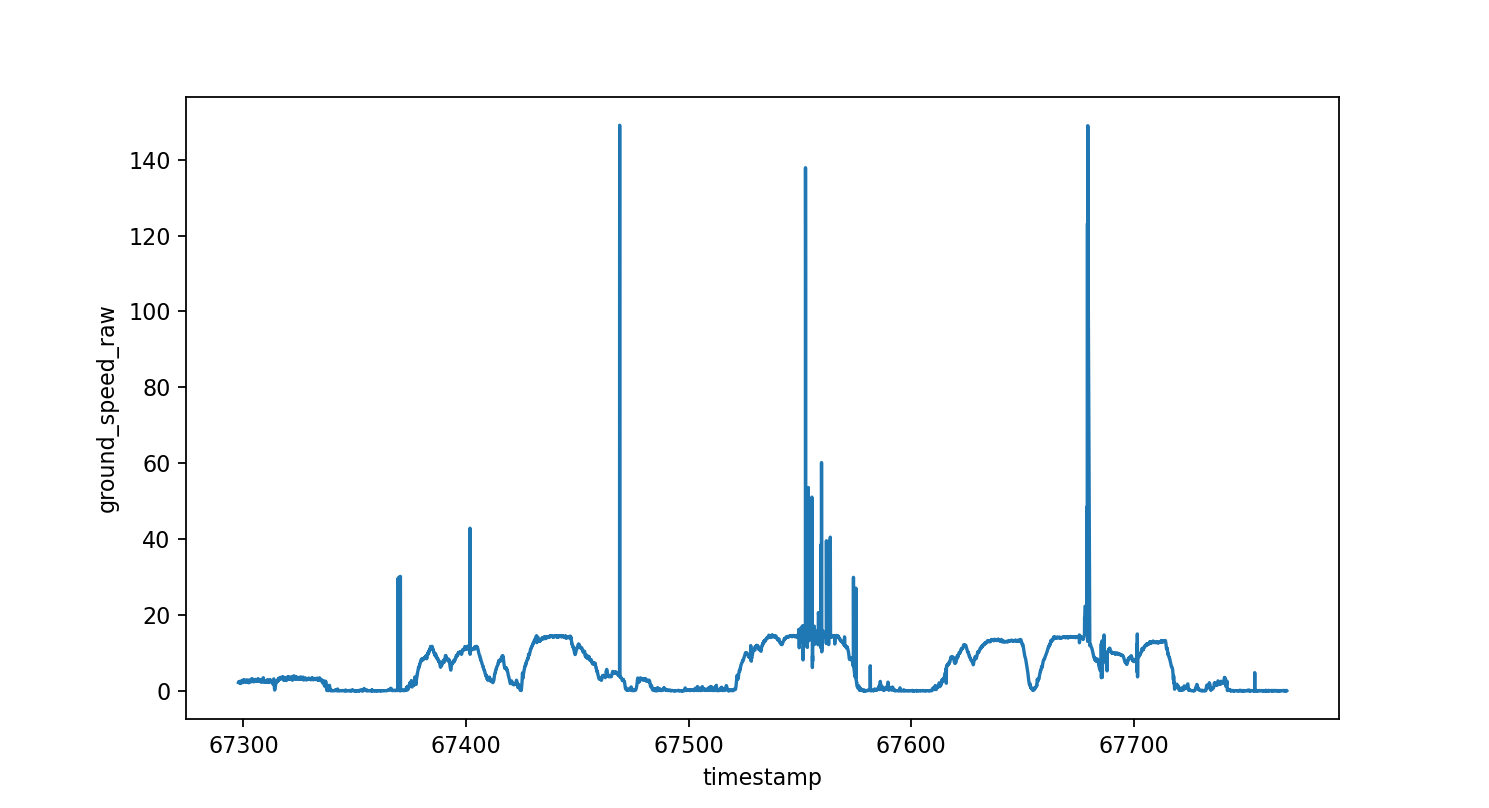

<AxesSubplot:xlabel='timestamp', ylabel='ground_speed_raw'>

<AxesSubplot:xlabel='timestamp', ylabel='rtktype'>

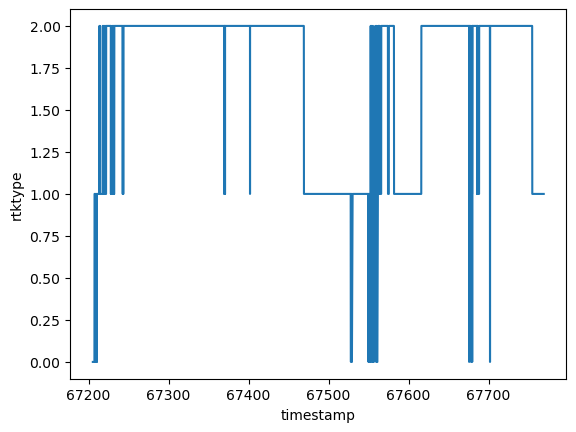